In [33]:
import os
import numpy as np
import pandas as pd
import glob
from tqdm.auto import tqdm

import torch
import torchaudio

from sklearn.model_selection    import train_test_split
from sklearn.preprocessing      import StandardScaler
from sklearn.pipeline           import Pipeline
from sklearn.ensemble           import RandomForestClassifier
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.svm                import SVC
from sklearn.semi_supervised    import LabelPropagation
from sklearn.metrics            import classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

DEVICE         = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATA_CSV       = './Data/data_labeled_filtered.csv'
AUDIO_ROOT     = './Data/Audio'
SAMPLES_PER_LABEL = 15000
N_MFCC         = 40
N_MELS         = 64
TEST_SIZE      = 0.2
RANDOM_STATE   = 42

In [34]:
df = pd.read_csv(DATA_CSV)

display(df.head())
print("Per‐class counts:\n", df['label'].value_counts())

,path,sentence,up_votes,down_votes,age,gender,accent,label,source
0,common_voice_en_19687170.mp3,He associated with the Formists.,2,1,0,0,us,3,Audio
1,common_voice_en_19687171.mp3,"The ""ultra accelerator"" injection gives Derric...",2,1,0,0,us,3,Audio
2,common_voice_en_19687172.mp3,"Despite running as a joke, candidates have won...",2,0,0,0,us,3,Audio
3,common_voice_en_19687173.mp3,Stoner also guest-starred in the television dr...,2,0,0,0,us,3,Audio
4,common_voice_en_19687174.mp3,Rainelle was named for the Raine family.,2,0,0,0,us,3,Audio


Per‐class counts:
 0    119700
1     19341
2     17292
3     15825
Name: label, dtype: int64


In [35]:
n_fft      = 512
hop_length = 256
n_mels     = 64

melspec_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=16000,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels,
).to(DEVICE)

mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=16000,
    n_mfcc=N_MFCC,
    melkwargs={
        'n_fft':       n_fft,
        'hop_length':  hop_length,
        'n_mels':      n_mels,
    }
).to(DEVICE)

In [36]:
X = df.drop(columns=['age'])
y = df['age'].values
y_gender = df['gender'].values
assert len(X) == len(y) == len(y_gender), "Mismatch in feature/label lengths!"

female_mask = (y_gender == 0)
male_mask   = (y_gender == 1)

X_female = X[female_mask]
y_female_age = y[female_mask]

X_male = X[male_mask]
y_male_age = y[male_mask]

In [37]:
X_train_male, X_main_male, y_train_male, y_main_male = train_test_split(
    X_male,
    y_male_age,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_male_age
)

X_test_male, X_val_male, y_test_male, y_val_male = train_test_split(
    X_main_male,
    y_main_male,
    test_size=0.5,
    random_state=RANDOM_STATE,
    stratify=y_main_male
)

print(f"Train set size: {len(X_train_male)}")
print(f"Test set size: {len(X_test_male)}")
print(f"Validation set size: {len(X_val_male)}")

Train set size: 109593
Test set size: 13699
Validation set size: 13700


In [38]:
X_train_female, X_main_female, y_train_female, y_main_female = train_test_split(
    X_female,
    y_female_age,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_female_age
)

X_test_female, X_val_female, y_test_female, y_val_female = train_test_split(
    X_main_female,
    y_main_female,
    test_size=0.5,
    random_state=RANDOM_STATE,
    stratify=y_main_female
)

print(f"Train set size: {len(X_train_female)}")
print(f"Test set size: {len(X_test_female)}")
print(f"Validation set size: {len(X_val_female)}")

Train set size: 28132
Test set size: 3517
Validation set size: 3517


In [39]:
display(X_train_male.head())

,path,sentence,up_votes,down_votes,gender,accent,label,source
98759,common_voice_en_17269443.mp3,Confronted with a choice between cappuccino an...,2,0,1,us,0,Audio
78295,common_voice_en_17368802.mp3,"The rainforests are depleted, we turned the pl...",2,0,1,NaN,0,Audio
92417,common_voice_en_194335.mp3,The hunter was alerted by the sound of rustlin...,2,0,1,canada,0,Audio
70237,common_voice_en_18850321.mp3,This caused additional conflict between Kun an...,2,1,1,NaN,0,Audio
69850,common_voice_en_19547585.mp3,He was one the original members of the board o...,2,0,1,us,0,Audio


In [40]:
display(X_train_female.head())

,path,sentence,up_votes,down_votes,gender,accent,label,source
57657,common_voice_en_18738653.mp3,A force transducer mounted on one of the wheel...,2,0,0,indian,1,Audio
80081,common_voice_en_18250541.mp3,How fast is your motorbike?,2,0,0,NaN,1,Audio
44345,common_voice_en_19872013.mp3,The Seitseminen national park is partly locate...,2,0,0,us,3,Audio
29348,common_voice_en_19720733.mp3,Merle Kendrick conducted the orchestra.,2,0,0,us,3,Audio
123366,common_voice_en_18340491.mp3,She hired a transit van when she moved out of ...,2,0,0,NaN,1,Audio


In [41]:
features, labels = [], []

def add_gaussian_noise(waveform, noise_level=0.005):
    noise = torch.randn_like(waveform) * noise_level
    return waveform + noise

def extract_with_augmentation(paths, labels, augment_noise=True):
    features, final_labels = [], []

    for path, label in tqdm(zip(paths, labels), total=len(paths), desc="Extracting"):
        full_path = os.path.join(AUDIO_ROOT, path)
        waveform, sr = torchaudio.load(full_path)
        waveform = waveform.to(DEVICE)

        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        waveform = torch.where(waveform.abs() < 1e-4,
                               torch.zeros_like(waveform),
                               waveform)

        def extract_feats(wave):
            mfcc = mfcc_transform(wave)
            melspec = melspec_transform(wave)
            mfcc_mean = mfcc.mean(dim=2).squeeze(0)
            mfcc_var  = mfcc.var(dim=2).squeeze(0)
            spec_mean = melspec.mean(dim=2).squeeze(0)
            spec_var  = melspec.var(dim=2).squeeze(0)
            return torch.cat([mfcc_mean, mfcc_var, spec_mean, spec_var], dim=0)

        feat = extract_feats(waveform)
        features.append(feat.cpu().numpy())
        final_labels.append(label)

        if augment_noise:
            noisy_wave = add_gaussian_noise(waveform)
            feat_noisy = extract_feats(noisy_wave)
            features.append(feat_noisy.cpu().numpy())
            final_labels.append(label)

    return np.vstack(features), np.array(final_labels)


X_train_male_feats, y_train_male_feats = extract_with_augmentation(X_train_male['path'], y_train_male)
X_test_male_feats,  y_test_male_feats  = extract_with_augmentation(X_test_male['path'],  y_test_male)
X_val_male_feats,   y_val_male_feats   = extract_with_augmentation(X_val_male['path'],   y_val_male)

X_train_female_feats, y_train_female_feats = extract_with_augmentation(X_train_female['path'], y_train_female)
X_test_female_feats,  y_test_female_feats  = extract_with_augmentation(X_test_female['path'],  y_test_female)
X_val_female_feats,   y_val_female_feats   = extract_with_augmentation(X_val_female['path'],   y_val_female)

Extracting: 100%|██████████| 3517/3517 [01:03<00:00, 55.41it/s]


In [42]:
def save_features_to_csv(features, labels, filename):
    df = pd.DataFrame(features)
    df['label'] = labels
    df.to_csv(filename, index=False)

save_features_to_csv(X_train_male_feats, y_train_male_feats, "train_male.csv")
save_features_to_csv(X_test_male_feats,  y_test_male_feats,  "test_male.csv")
save_features_to_csv(X_val_male_feats,   y_val_male_feats,   "val_male.csv")

save_features_to_csv(X_train_female_feats, y_train_female_feats, "train_female.csv")
save_features_to_csv(X_test_female_feats,  y_test_female_feats,  "test_female.csv")
save_features_to_csv(X_val_female_feats,   y_val_female_feats,   "val_female.csv")


## Trial 2:

In [43]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, svd_solver='full')
X_train_male_pca = pca.fit_transform(X_train_male_feats)
X_test_male_pca  = pca.transform(X_test_male_feats)
X_val_male_pca  = pca.transform(X_val_male_feats)

In [44]:
from sklearn.model_selection    import train_test_split, GridSearchCV
from sklearn.preprocessing      import StandardScaler
from sklearn.feature_selection  import SelectKBest, f_classif
from sklearn.decomposition      import PCA
from sklearn.pipeline           import Pipeline
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.metrics            import classification_report, confusion_matrix
import matplotlib.pyplot        as plt
import seaborn                  as sns

# 6) Define three pipelines
pipelines_male = {
    'KNN_baseline_male': Pipeline([
        ('scaler', StandardScaler()),
        ('knn',    KNeighborsClassifier())
    ]),
    'KNN_selectK_male': Pipeline([
        ('scaler', StandardScaler()),
        ('kbest',  SelectKBest(score_func=f_classif, k=min(100, X_train_male_feats.shape[1] if X_train_male_feats.ndim > 1 and X_train_male_feats.shape[1] > 0 else 100))),
        ('knn',    KNeighborsClassifier())
    ]),
    'KNN_pca_male': Pipeline([
        ('scaler', StandardScaler()),
        ('pca',    PCA(n_components=0.95, svd_solver='full')),
        ('knn',    KNeighborsClassifier())
    ]),
}

# 7) Light grid over k in [3,5,7,9]
param_grid_male = {
    'knn__n_neighbors': [3, 5, 7, 9]
}

best_models_male = {} # Store best models found for males
print("--- Training Models on MALE Data ---")

# Check if there is enough data to train
if X_train_male_feats.shape[0] < 5: # Arbitrary small number, adjust if needed
    print(f"Skipping male model training: Insufficient training samples ({X_train_male_feats.shape[0]})")
elif len(np.unique(y_train_male_feats)) < 2:
     print(f"Skipping male model training: Only one class present in y_train_male_feats.")
else:
    for name, pipe in pipelines_male.items():
        print(f"\n=== Tuning {name} ===")
        # We only tune the 'knn' step in each pipeline
        # Setup GridSearchCV
        # Use cv=min(3, n_splits) if dataset is very small for stratification
        n_splits = min(3, min(np.unique(y_train_male_feats, return_counts=True)[1])) # Ensure CV folds <= smallest class count
        if n_splits < 2:
            print(f"  Cannot perform cross-validation with n_splits={n_splits}. Skipping tuning for {name}.")
            continue

        grid = GridSearchCV(pipe, param_grid_male, cv=n_splits, n_jobs=-1, verbose=1, scoring='accuracy') # Use accuracy or other metric

        # Fit GridSearchCV on the ORIGINAL male training data
        try:
            grid.fit(X_train_male_feats, y_train_male_feats)
            print("  Best k:", grid.best_params_['knn__n_neighbors'],
                  "| CV acc:", f"{grid.best_score_:.4f}")
            best_models_male[name] = grid.best_estimator_
        except ValueError as e:
             print(f"  ERROR during GridSearchCV for {name}: {e}")
             print(f"  Skipping this pipeline. Check data dimensionality, KBest k value, or PCA components.")

--- Training Models on MALE Data ---

=== Tuning KNN_baseline_male ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
  Best k: 3 | CV acc: 0.9691

=== Tuning KNN_selectK_male ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
  Best k: 3 | CV acc: 0.9651

=== Tuning KNN_pca_male ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
  Best k: 3 | CV acc: 0.9696



--- Evaluating Male Models on MALE Test Data ---

--- Test results for KNN_baseline_male ---
              precision    recall  f1-score   support

         50s     0.8995    0.8881    0.8938      3458
         20s     0.9839    0.9857    0.9848     23942

    accuracy                         0.9734     27400
   macro avg     0.9417    0.9369    0.9393     27400
weighted avg     0.9732    0.9734    0.9733     27400



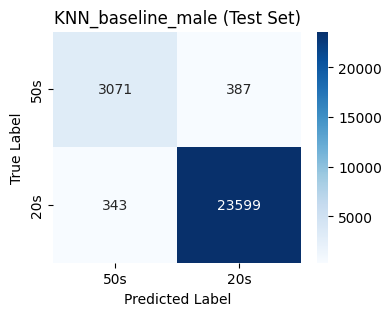


--- Test results for KNN_selectK_male ---
              precision    recall  f1-score   support

         50s     0.8872    0.8710    0.8790      3458
         20s     0.9814    0.9840    0.9827     23942

    accuracy                         0.9697     27400
   macro avg     0.9343    0.9275    0.9309     27400
weighted avg     0.9695    0.9697    0.9696     27400



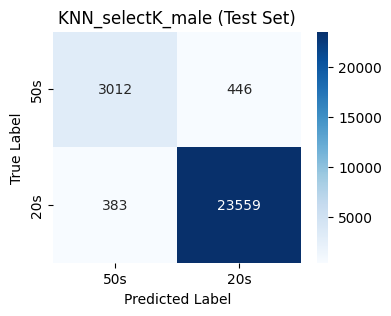


--- Test results for KNN_pca_male ---
              precision    recall  f1-score   support

         50s     0.9083    0.8875    0.8978      3458
         20s     0.9838    0.9871    0.9854     23942

    accuracy                         0.9745     27400
   macro avg     0.9460    0.9373    0.9416     27400
weighted avg     0.9743    0.9745    0.9744     27400



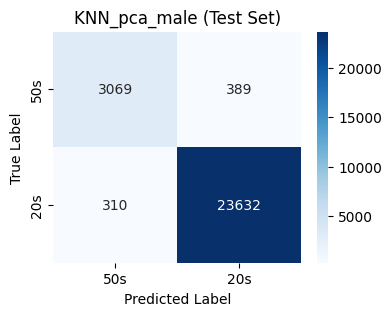

In [48]:
print("\n--- Evaluating Male Models on MALE Test Data ---")

# Make sure target names match your age encoding (e.g., 0='50s', 1='20s')
# Check your y variable's unique values and adjust if needed.
age_target_names = ['50s', '20s']
age_labels_numeric = sorted(np.unique(y_train_male_feats)) # Get the actual numeric labels [0, 1]
if len(age_labels_numeric) != len(age_target_names):
    print(f"Warning: Mismatch between number of unique age labels ({len(age_labels_numeric)}) and target names ({len(age_target_names)}). Using numeric labels.")
    target_names_display = [str(l) for l in age_labels_numeric]
    xticklabels_display = [str(l) for l in age_labels_numeric]
    yticklabels_display = [str(l) for l in age_labels_numeric]

else:
     target_names_display = age_target_names
     xticklabels_display=age_target_names
     yticklabels_display=age_target_names



if not best_models_male:
     print("No models were successfully trained for males.")
elif X_val_male_feats.shape[0] == 0:
     print("No test data available for males.")
else:
    for name, model in best_models_male.items():
        print(f"\n--- Test results for {name} ---")

        # Predict on the ORIGINAL male test data
        # The model pipeline handles scaling/pca/kbest transformation internally
        try:
            y_pred_male = model.predict(X_val_male_feats)

            print(classification_report(
                y_val_male_feats, y_pred_male,
                target_names=target_names_display,
                digits=4,
                zero_division=0 # Avoid warnings if a class has no test samples or predictions
            ))
            cm = confusion_matrix(y_val_male_feats, y_pred_male, labels=age_labels_numeric) # Ensure labels match numeric order
            plt.figure(figsize=(4,3))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=xticklabels_display, yticklabels=yticklabels_display)
            plt.title(f"{name} (Test Set)")
            plt.xlabel('Predicted Label'); plt.ylabel('True Label')
            plt.show()
        except Exception as e:
            print(f"  ERROR during prediction or evaluation for {name}: {e}")

In [49]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, svd_solver='full')
X_train_female_feats_pca = pca.fit_transform(X_train_female_feats)
X_test_female_feats_pca  = pca.transform(X_test_female_feats)

In [50]:
from sklearn.model_selection    import train_test_split, GridSearchCV
from sklearn.preprocessing      import StandardScaler
from sklearn.feature_selection  import SelectKBest, f_classif
from sklearn.decomposition      import PCA
from sklearn.pipeline           import Pipeline
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.metrics            import classification_report, confusion_matrix
import matplotlib.pyplot        as plt
import seaborn                  as sns

# 6) Define three pipelines
pipelines_female = {
    'KNN_baseline_female': Pipeline([
        ('scaler', StandardScaler()),
        ('knn',    KNeighborsClassifier())
    ]),
    'KNN_selectK_female': Pipeline([
        ('scaler', StandardScaler()),
        ('kbest',  SelectKBest(score_func=f_classif, k=min(100, X_train_female_feats.shape[1] if X_train_female_feats.ndim > 1 and X_train_female_feats.shape[1] > 0 else 100))),
        ('knn',    KNeighborsClassifier())
    ]),
    'KNN_pca_female': Pipeline([
        ('scaler', StandardScaler()),
        ('pca',    PCA(n_components=0.95, svd_solver='full')),
        ('knn',    KNeighborsClassifier())
    ]),
}

param_grid_female = {
    'knn__n_neighbors': [3, 5, 7, 9]
}

best_models_female = {}
print("--- Training Models on female Data ---")

if X_train_female_feats.shape[0] < 5:
    print(f"Skipping female model training: Insufficient training samples ({X_train_female_feats.shape[0]})")
elif len(np.unique(y_train_female_feats)) < 2:
     print(f"Skipping female model training: Only one class present in y_train_female_feats.")
else:
    for name, pipe in pipelines_female.items():
        print(f"\n=== Tuning {name} ===")

        n_splits = min(3, min(np.unique(y_train_female_feats, return_counts=True)[1]))
        if n_splits < 2:
            print(f"  Cannot perform cross-validation with n_splits={n_splits}. Skipping tuning for {name}.")
            continue

        grid = GridSearchCV(pipe, param_grid_female, cv=n_splits, n_jobs=-1, verbose=1, scoring='accuracy')

        try:
            grid.fit(X_train_female_feats, y_train_female_feats)
            print("  Best k:", grid.best_params_['knn__n_neighbors'],
                  "| CV acc:", f"{grid.best_score_:.4f}")
            best_models_female[name] = grid.best_estimator_
        except ValueError as e:
             print(f"  ERROR during GridSearchCV for {name}: {e}")
             print(f"  Skipping this pipeline. Check data dimensionality, KBest k value, or PCA components.")

--- Training Models on female Data ---

=== Tuning KNN_baseline_female ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
  Best k: 3 | CV acc: 0.9438

=== Tuning KNN_selectK_female ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
  Best k: 3 | CV acc: 0.9345

=== Tuning KNN_pca_female ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
  Best k: 3 | CV acc: 0.9440



--- Evaluating female Models on female Test Data ---

--- Test results for KNN_baseline_female ---
              precision    recall  f1-score   support

         50s     0.9357    0.9564    0.9460      3166
         20s     0.9637    0.9462    0.9549      3868

    accuracy                         0.9508      7034
   macro avg     0.9497    0.9513    0.9504      7034
weighted avg     0.9511    0.9508    0.9509      7034



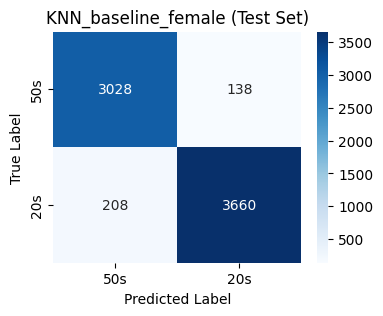


--- Test results for KNN_selectK_female ---
              precision    recall  f1-score   support

         50s     0.9252    0.9536    0.9392      3166
         20s     0.9610    0.9369    0.9488      3868

    accuracy                         0.9444      7034
   macro avg     0.9431    0.9452    0.9440      7034
weighted avg     0.9449    0.9444    0.9445      7034



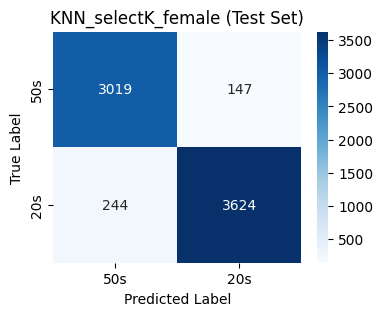


--- Test results for KNN_pca_female ---
              precision    recall  f1-score   support

         50s     0.9372    0.9567    0.9469      3166
         20s     0.9640    0.9475    0.9557      3868

    accuracy                         0.9517      7034
   macro avg     0.9506    0.9521    0.9513      7034
weighted avg     0.9519    0.9517    0.9517      7034



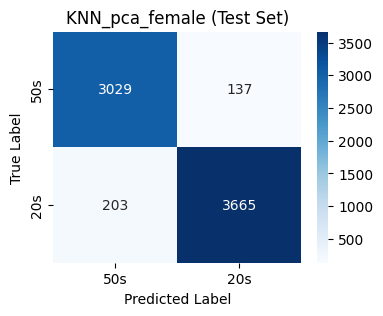

In [58]:
print("\n--- Evaluating female Models on female Test Data ---")

age_target_names = ['50s', '20s']
age_labels_numeric = sorted(np.unique(y_train_female_feats))
if len(age_labels_numeric) != len(age_target_names):
    print(f"Warning: Mismatch between number of unique age labels ({len(age_labels_numeric)}) and target names ({len(age_target_names)}). Using numeric labels.")
    target_names_display = [str(l) for l in age_labels_numeric]
    xticklabels_display = [str(l) for l in age_labels_numeric]
    yticklabels_display = [str(l) for l in age_labels_numeric]
else:
     target_names_display = age_target_names
     xticklabels_display=age_target_names
     yticklabels_display=age_target_names

if not best_models_female:
     print("No models were successfully trained for females.")
elif X_val_female_feats.shape[0] == 0:
     print("No test data available for females.")
else:
    for name, model in best_models_female.items():
        print(f"\n--- Test results for {name} ---")

        try:
            y_pred_female = model.predict(X_val_female_feats)

            print(classification_report(
                y_val_female_feats, y_pred_female,
                target_names=target_names_display,
                digits=4,
                zero_division=0
            ))
            cm = confusion_matrix(y_val_female_feats, y_pred_female, labels=age_labels_numeric)
            plt.figure(figsize=(4,3))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=xticklabels_display, yticklabels=yticklabels_display)
            plt.title(f"{name} (Test Set)")
            plt.xlabel('Predicted Label'); plt.ylabel('True Label')
            plt.show()
        except Exception as e:
            print(f"  ERROR during prediction or evaluation for {name}: {e}")

### Model Evaluation:


--- Evaluating male Models on male Test Data ---
              precision    recall  f1-score   support

         50s     0.9116    0.8855    0.8983      3458
         20s     0.9835    0.9876    0.9856     23940

    accuracy                         0.9747     27398
   macro avg     0.9476    0.9365    0.9419     27398
weighted avg     0.9744    0.9747    0.9745     27398



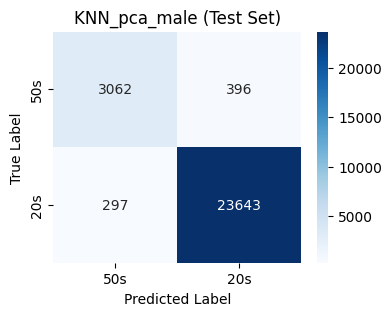

In [55]:
print("\n--- Evaluating male Models on male Test Data ---")

model = best_models_male['KNN_pca_male']

age_target_names = ['50s', '20s']
age_labels_numeric = sorted(np.unique(y_train_male_feats))

target_names_display = age_target_names
xticklabels_display=age_target_names
yticklabels_display=age_target_names

y_pred_male = model.predict(X_test_male_feats)

print(classification_report(
    y_test_male_feats, y_pred_male,
    target_names=target_names_display,
    digits=4,
    zero_division=0
))
cm = confusion_matrix(y_test_male_feats, y_pred_male, labels=age_labels_numeric)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=xticklabels_display, yticklabels=yticklabels_display)
plt.title(f"{name} (Test Set)")
plt.xlabel('Predicted Label'); plt.ylabel('True Label')
plt.show()


--- Evaluating female Models on female Test Data ---
              precision    recall  f1-score   support

         50s     0.9450    0.9608    0.9528      3164
         20s     0.9675    0.9543    0.9608      3870

    accuracy                         0.9572      7034
   macro avg     0.9562    0.9575    0.9568      7034
weighted avg     0.9574    0.9572    0.9572      7034



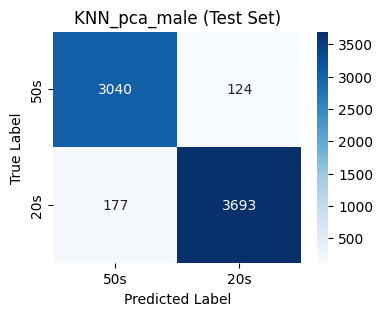

In [56]:
print("\n--- Evaluating female Models on female Test Data ---")

model = best_models_female['KNN_pca_female']

age_target_names = ['50s', '20s']
age_labels_numeric = sorted(np.unique(y_train_female_feats))

target_names_display = age_target_names
xticklabels_display=age_target_names
yticklabels_display=age_target_names

y_pred_female = model.predict(X_test_female_feats)

print(classification_report(
    y_test_female_feats, y_pred_female,
    target_names=target_names_display,
    digits=4,
    zero_division=0
))
cm = confusion_matrix(y_test_female_feats, y_pred_female, labels=age_labels_numeric)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=xticklabels_display, yticklabels=yticklabels_display)
plt.title(f"{name} (Test Set)")
plt.xlabel('Predicted Label'); plt.ylabel('True Label')
plt.show()

In [52]:
from joblib import dump

for name, pipe in pipelines_female.items():
    dump(best_models_female[name], f'female_{name}')

for name, pipe in pipelines_male.items():
    dump(best_models_male[name], f'male_{name}')